In [1]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import albumentations as A
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
XML_ROOT = "/kaggle/input/dog-and-cat-detection/annotations/"
IMG_ROOT = "/kaggle/input/dog-and-cat-detection/images/"

In [3]:
def parse_xml(fp):
    obj = {}
    tree = ET.parse(fp)
    root = tree.getroot()
    for x in root:
        if x.tag == 'object':
            for xx in x:
                if xx.tag == 'name':
                    obj['name'] = xx.text
                elif xx.tag == 'bndbox':
                    box = []
                    for xxx in xx:
                        box.append(float(xxx.text))
                    obj['bbox'] = box
                elif xx.tag == 'occluded':
                    obj['occluded'] = int(xx.text)
                elif xx.tag == 'difficult':
                    obj['difficult'] = int(xx.text)
        elif x.tag == 'filename':
            obj['filename'] = x.text
        elif x.tag == 'size':
            size =  []
            for xx in x:
                size.append(int(xx.text))
            obj['size'] = size
    return obj

def plot_bbox(box, c='red'):
    x1, y1, x2, y2 = map(int, box)
    plt.vlines(x1, y1, y2, color=c)
    plt.vlines(x2, y1, y2, color=c)
    plt.hlines(y1, x1, x2, color=c)
    plt.hlines(y2, x1, x2, color=c)
    
def load_sample(xml_fp):
    obj = parse_xml(os.path.join(XML_ROOT, xml_fp))
    img_fp = os.path.join(IMG_ROOT, obj['filename'])
    assert os.path.exists(img_fp)
    img =  cv2.imread(img_fp)[..., ::-1]
    return img, obj

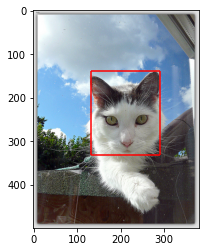

In [4]:
xml_fp = random.sample(os.listdir(XML_ROOT), 1)[0]
img, ann = load_sample(xml_fp)

plt.imshow(img)
plot_bbox(ann['bbox'])

In [5]:
class UnetConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.2):
        super(UnetConvBlock, self).__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.bn1(x)
        x = nn.Dropout(self.dropout)(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.bn2(x)
        return x
    
class UnetBlockUp(nn.Module):
    def __init__(self, in_ch, prev_ch=None, up_type='upsample'):
        super(UnetBlockUp, self).__init__()
        out_ch = in_ch // 2
        if prev_ch is None:
            prev_ch = out_ch
        if up_type == 'upsample':
            self.upconv = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_ch, out_ch, 1),
            )
        else:
            self.upconv = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.conv = UnetConvBlock(out_ch + prev_ch, out_ch, dropout=0)
        
    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], 1)
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, num_classes=2, dropout=0.2, activation=None):
        super(Unet, self).__init__()
        self.num_classes = num_classes
        self.activation = activation
        self.dropout = dropout
        
        self.pool = nn.MaxPool2d(2)
        self.down1 = UnetConvBlock(3, 64, dropout)
        self.down2 = UnetConvBlock(64, 128, dropout)
        self.down3 = UnetConvBlock(128, 256, dropout)
        self.down4 = UnetConvBlock(256, 512, dropout)
        self.down5 = UnetConvBlock(512, 1024, dropout)
        
        self.up5 = UnetBlockUp(1024)
        self.up4 = UnetBlockUp(512)
        self.up3 = UnetBlockUp(256)
        self.up2 = UnetBlockUp(128)
        self.final = nn.Conv2d(64, num_classes, 1)
        
    def forward(self, x):
        down1 = self.down1(x)
        x = self.pool(down1)
        down2 = self.down2(x)
        x = self.pool(down2)
        down3 = self.down3(x)
        x = self.pool(down3)
        down4 = self.down4(x)
        x = self.pool(down4)
        down5 = self.down5(x)
        
        up5 = self.up5(down5, down4)
        up4 = self.up4(up5, down3)
        up3 = self.up3(up4, down2)
        up2 = self.up2(up3, down1)
        out = self.final(up2)
        if self.activation == 'sigmoid':
            out = torch.sigmoid(out)
        return out
    

In [6]:
class UnetResnet50(nn.Module):
    def __init__(self, num_classes=2, dropout=0.2, activation=None):
        super(UnetResnet50, self).__init__()
        base_model = torchvision.models.resnet50(pretrained=True)
        self.activation = activation
        self.down1 = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu
        )
        self.down2 = nn.Sequential(
            base_model.maxpool,
            base_model.layer1,
        )
        self.down3 = base_model.layer2
        self.down4 = base_model.layer3
        
        self.up4 = UnetBlockUp(1024)
        self.up3 = UnetBlockUp(512)
        self.up2 = UnetBlockUp(256, prev_ch=64)
        
        self.final = nn.Sequential(
            UnetConvBlock(128, 32),
            nn.Conv2d(32, num_classes, 1)
        )
        
        
    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        
        up4 = self.up4(down4, down3)
        up3 = self.up3(up4, down2)
        up2 = self.up2(up3, down1)
        out = self.final(up2)
        if self.activation == 'sigmoid':
            return torch.sigmoid(out)
        return out

In [7]:
unet = UnetResnet50()
inp = torch.rand(1, 3, 256, 256)
unet(inp).shape

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 2, 128, 128])

In [8]:
transform_fn = A.Compose([
    A.RandomBrightnessContrast(),
    A.HorizontalFlip(),
    A.Rotate(60),
    A.GaussNoise(),
    A.ChannelShuffle(),
])

normalize_fn = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

In [9]:
class CatDogDataset:
    def __init__(self, xml_dir, img_dir, xml_fps, shape=(256, 256), num_classes=2,  mask_scale=2, split='train'):
        super(CatDogDataset, self).__init__()
        self.xml_dir = xml_dir
        self.img_dir = img_dir
        self.xml_fps = xml_fps
        self.shape = shape
        self.mask_scale = mask_scale
        self.mask_shape = [int(x / self.mask_scale) for x in self.shape]
        self.num_classes = num_classes
        self.class_idx = {'cat': 0, 'dog': 1}
        self.split = split
        
    def _load_sample(self, xml_fp):
        obj = parse_xml(os.path.join(self.xml_dir, xml_fp))
        img_fp = os.path.join(self.img_dir, obj['filename'])
        assert os.path.exists(img_fp)
        img =  cv2.imread(img_fp)[..., ::-1]
        
        return img, obj
    
    def _preprocess_image(self, img, bbox):
        pad_h, pad_w = 0, 0
        h, w, _ = img.shape
        if h > w:
            pad = int((h - w) / 2)
            pad_w = pad
            img = np.pad(img, ((0,  0), (pad, pad), (0, 0)))
        else:
            pad = int((w - h) / 2)
            pad_h = pad
            img = np.pad(img, ((pad, pad), (0,  0), (0, 0)))
        h, w, _ = img.shape
        img = cv2.resize(img, self.shape)
        H, W, _ = img.shape
        scale_x, scale_y = w / W, h / H
        x1, y1, x2, y2 = bbox
        x1, x2 = (x1 + pad_w) / scale_x, (x2 + pad_w) / scale_x
        y1, y2 = (y1 + pad_h) / scale_y, (y2 + pad_h) / scale_y
        return img, (pad_h, pad_w), (x1, y1, x2, y2)
    
    def _bbox_to_mask(self, bbox):
        mask = np.zeros(self.mask_shape)
        h, w = self.shape
        x1, y1, x2, y2 = map(int, bbox)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(x2, w-1), min(y2, h-1)
        if self.mask_scale > 1:
            x1, y1, x2, y2 = [int(t / self.mask_scale) for t in (x1, y1, x2, y2)]
        mask[y1:y2, x1:x2] = 1
        return mask
    
    def __getitem__(self, idx):
        if self.split == 'train':
            idx = random.randint(0, len(self)-1)
        xml_fp = self.xml_fps[idx]
        xml_fp = os.path.join(self.xml_dir, xml_fp)
        img, ann = self._load_sample(xml_fp)
        img, pads, bbox = self._preprocess_image(img, ann['bbox'])
        
        mask = np.zeros((self.num_classes, *self.mask_shape))
        _ch = self.class_idx[ann['name']]
        _mask = self._bbox_to_mask(bbox)
        
        if self.split == 'train':
            args = {'image': img, 'mask': _mask}
            augm = transform_fn(**args)
            img, _mask = augm['image'], augm['mask']
        mask[_ch] += _mask
        img = (img / 255.)
        img = normalize_fn(img).float()
        mask = torch.from_numpy(mask).float()
        return img, mask
        
    def __len__(self):
        return len(self.xml_fps)

In [10]:
fps = [x for x in os.listdir(XML_ROOT) if '.xml' in x]

TRAIN, TEST = train_test_split(fps, test_size=0.1, random_state=1) 
data = CatDogDataset(XML_ROOT, IMG_ROOT, TEST)
x, y = data[0]
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([2, 128, 128]))

In [11]:
class DICEMetrics:
    eps = 1e-7

    def __init__(self, size_average=True, num_classes=2):
        self.size_average = size_average
        self.num_classes = num_classes

    def __call__(self, outputs, targets):
        batch_size = outputs.size(0)
        outputs = outputs.view(batch_size, self.num_classes, -1)
        targets = targets.view(batch_size, self.num_classes, -1)
        nominator = (outputs * targets).sum(dim=2)
        denominator = outputs.sum(dim=2) + targets.sum(dim=2)

        if self.size_average:
            return ((2. * nominator + self.eps) / (denominator + self.eps)).mean()
        return (2. * nominator + self.eps) / (denominator + self.eps)
    
class BCEDICELoss:
    def __init__(self, loss_weights=None, size_average=True, num_classes=2):
        loss_weights = loss_weights or {'bce': 0.5, 'dice': 0.5}
        self.bce_loss = nn.BCELoss(reduction='elementwise_mean' if size_average else 'none')
        self.dice_loss = DICEMetrics(size_average=size_average, num_classes=num_classes)
        self.loss_weights = loss_weights
        self.size_average = size_average
        self.num_classes = num_classes

    def __call__(self, outputs, targets):
        if self.size_average:
            bce_loss = self.loss_weights['bce'] * self.bce_loss(outputs, targets)
        else:
            bce_loss = (self.loss_weights['bce'] * self.bce_loss(outputs, targets)).view(outputs.size(0), -1).mean()
        return bce_loss \
               + self.loss_weights['dice'] * (1 - self.dice_loss(outputs, targets))

In [12]:
def train_single_epoch(unet, data_loader, b_size, epoch,criterion, optimizer):
    total_loss = 0.
    unet.train()
    unet.zero_grad()
    total_steps = len(data_loader)
    postfix_dict = {}
    tbar = tqdm(enumerate(data_loader), total=total_steps, position=0, leave=True)
    
    for i, (img, mask) in tbar:
        img = img.cuda()
        mask = mask.cuda()
        out = unet(img)
        loss = criterion(out, mask)
        loss.backward()
        optimizer.step()
        total_loss = 0.5 * total_loss + 0.5 * loss.item()
        postfix_dict["train/loss"] = total_loss
        f_epoch = epoch + i / total_steps
        desc = '{:04d}/{:04d}, {:.2f} epoch'.format(i, total_steps, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)
    return total_loss
    
def evaluate_single_epoch(unet, data_loader, b_size, epoch, criterion):
    total_loss = 0.
    unet.eval()
    total_steps = len(data_loader)
    postfix_dict = {}
    tbar = tqdm(enumerate(data_loader), total=total_steps, position=0, leave=True)
        
    with torch.no_grad():
        for i, (img, mask) in tbar:
            img = img.cuda()
            mask = mask.cuda()
            out = unet(img)
            loss = criterion(out, mask)
            total_loss = 0.5 * total_loss + 0.5 * loss.item()
            postfix_dict["val/loss"] = total_loss
            f_epoch = epoch + i / total_steps
            desc = '{:04d}/{:04d}, {:.2f} epoch'.format(i, total_steps, f_epoch)
            tbar.set_description(desc)
            tbar.set_postfix(**postfix_dict)
    return total_loss
    
def save_model(model, epoch, name):
    fp = os.path.join("../working/", name + '.pth')
    ckpt = {'state_dict': model.state_dict(),
            'epoch': epoch}
    torch.save(ckpt, fp)

def train(epochs, b_size=16, shape=(256, 256)):
    train = CatDogDataset(XML_ROOT, IMG_ROOT, TRAIN, shape=shape, mask_scale=2, split='train')
    train_loader = DataLoader(train, batch_size=b_size, 
                             num_workers=8, drop_last=True, shuffle=True)
    test = CatDogDataset(XML_ROOT, IMG_ROOT, TEST, shape=shape, mask_scale=2, split='val')
    test_loader = DataLoader(test, batch_size=b_size, 
                             num_workers=8, drop_last=True, shuffle=True)
    
    unet = UnetResnet50(dropout=0.5, activation='sigmoid').cuda()
    
    criterion = BCEDICELoss()
    dice_metrics = DICEMetrics()
    lr = 5e-5
    optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
    prev_test_loss = None
    
    for epoch in range(epochs):
        train_single_epoch(unet, train_loader, b_size, epoch,
                           criterion, optimizer)
        total = evaluate_single_epoch(unet, test_loader, b_size, epoch, dice_metrics)
        if prev_test_loss is None or total > prev_test_loss:
            prev_test_loss = total
            save_model(unet, epoch, "unet")

In [13]:
train(70, b_size=32)

  0%|          | 0/103 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")
0102/0103, 43.99 epoch: 100%|██████████| 103/103 [01:07<00:00,  1.52it/s, train/loss=0.47] 


0010/0011, 69.91 epoch: 100%|██████████| 11/11 [00:04<00:00,  2.48it/s, val/loss=0.382]


In [17]:
unet = UnetResnet50(activation='sigmoid')
unet = unet.eval()

ckpt = torch.load("../working/unet.pth")
unet.load_state_dict(ckpt['state_dict'])
print(ckpt['epoch'])

61


In [18]:
def post_process(out, mask_tresh=0.1, size_tresh=10):
    dets = []
    ch, h, w = out.shape
    for i in range(ch):
        temp = (out[i, :, :] > mask_tresh) * 255
        temp = temp.astype(np.uint8)
        num, labels, stats, cents = cv2.connectedComponentsWithStats(temp)     
        if len(stats) <= 1:
            continue
        for stat in stats[1:]:
            x1, y1, w, h, _ = stat
            if min(w, h) < size_tresh:
                continue
            dets.append([i, x1, y1, x1 + w, y1 + h])
    return dets

In [20]:
data = CatDogDataset(XML_ROOT, IMG_ROOT, TEST, shape=(256, 256), split='val')

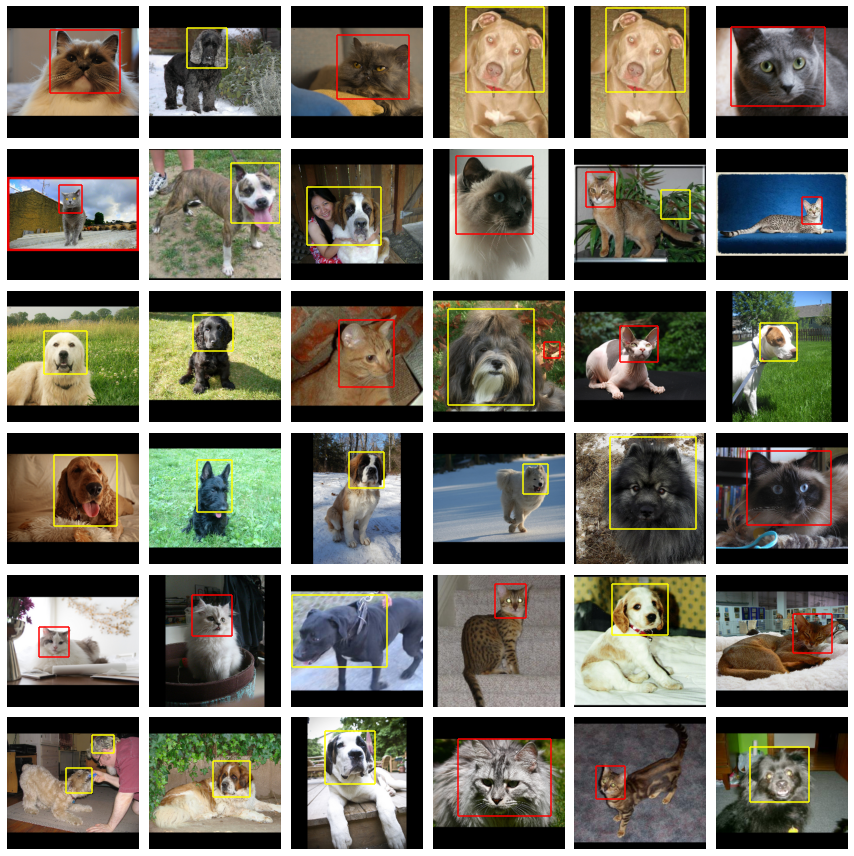

In [30]:
plt.figure(figsize=(12, 12))

for i in range(36):
    x, y = data[random.randint(0, len(data)-1)]
    out = unet(x[None])
    img = 0.5 + 0.5 * x.detach().numpy().transpose(1, 2, 0)
    plt.subplot(6, 6, i+1)
    plt.imshow(img)
    dets = post_process(out[0].detach().cpu().numpy(), mask_tresh=0.7, size_tresh=15)
    for det in dets:
        cl = det[0]
        x1, y1, x2, y2 = [int(t) * 2 for t in det[1:]]
        color = 'red' if cl == 0 else 'yellow'
        plot_bbox((x1, y1, x2, y2), color)
    plt.axis('off')
plt.tight_layout()

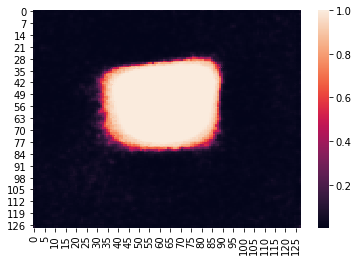

In [31]:
sns.heatmap(out[0, 1].detach().cpu())